In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
from functools import partial
from progressbar import progressbar
from statsmodels.stats.proportion import proportions_ztest
from functools import partial
import matplotlib.pyplot as plt
plt.rcParams.update({
    "lines.color": "white",
    "patch.edgecolor": "white",
    "text.color": "black",
    "axes.facecolor": "white",
    "axes.edgecolor": "lightgray",
    "axes.labelcolor": "white",
    "xtick.color": "white",
    "ytick.color": "white",
    "grid.color": "lightgray",
    "figure.facecolor": "black",
    "figure.edgecolor": "black",
    "savefig.facecolor": "black",
    "savefig.edgecolor": "black"})

## Decision strategies

This final section examines the performance of various decision strategies.

- The story: We run 200 experiments per week for 52 weeks. That's ~10000 experiments in total.
- Each experiment has $N=50$ observations. The observations are split into 2 groups, one control and one treatment. The true success probabilities for each group are drawn from independent $Beta(\alpha, \beta)$ distributions.
- We simulate running various decision strategies against these data sets. The **performance** of a strategy is the average probability of of the group (treatment or control) that the strategy picked on average across all the experiments that the company ran.
- The key decision strategies we will look at are: (1) one-tailed tests with various $\alpha$ levels, (2) a Bayesian decision strategy with correct priors, (3) a coin flipping strategy, and (4) an oracle that always chooses the best arm.

In [2]:
def gen_one_dataset(aC, bC, aT, bT, N=50):
  """Generate data from one experiment from Beta-Binomial dgp."""

  p_control = np.random.beta(aC, bC)
  p_treatment = np.random.beta(aT, bT)

  y_size = (int(N / 2), 1)
  Y_control = np.random.binomial(n=1, p=p_control, size=y_size)
  Y_treatment = np.random.binomial(n=1, p=p_treatment, size=y_size)
  

  # Stack the groups side by side in a (N/2, 2) array.
  return (np.array([p_control, p_treatment]).flatten(), np.hstack((Y_control, Y_treatment)))

In [3]:
# alternative str in [‘two-sided’, ‘smaller’, ‘larger’]
def stats_prop_test(e1, e2, n1, n2, alternative):
    counts = np.array([e1, e2]).astype('float')
    sample_sizes = np.array([n1, n1]).astype('float')
    z, p = proportions_ztest(counts, sample_sizes, value=0, alternative=alternative)
    return {'z': z, 'p_value': p}

In [4]:
def choose_prop_test(df, alpha, alternative):
  """Choose treatment iff the proportion test is significant at level alpha.
  
  alternative = `smaller` is the hypothesis that the left column (control)
  has a lower probability than the right (treatment)
  """
  events = df.sum(axis=0)
  n_per_group = len(df)
  results = stats_prop_test(events[0], events[1], n_per_group, n_per_group, alternative=alternative)
  return int(results['z'] < 0 and results['p_value'] < alpha)
  
def choose_bayesian(df, pri_aC, pri_bC, pri_aT, pri_bT):
  """Choose treatment iff posterior mean is higher."""
  sums = df.sum(axis=0)
  # Bayesian update of the parameters
  aC, bC = pri_aC + sums[0], pri_bC + len(df) - sums[0]
  aT, bT = pri_aT + sums[1], pri_bT + len(df) - sums[1]
  # Compare posterior means
  return int(aT / (aT + bT) > aC / (aC + bC))


In [5]:
def scenario(dgp, total_experiments=1000):
  sims = [dgp() for _ in progressbar(np.arange(total_experiments))]
  
  # Get array with control and treatment conversion rates
  # Stack the arrays vertically
  p_conversion = np.vstack([pp for pp, _ in sims])

  choices_random = np.random.binomial(n=1, p=0.5, size=len(sims))

  choices_oracle = p_conversion.argmax(axis=1)

  choices_correct_bayesian = [choose_bayesian(df, *dgp.args) for _, df in progressbar(sims)]

  #choices_prop_test_two_01 = [choose_prop_test(df, 0.01,  'two-sided') for _, df in progressbar(sims)]
  #choices_prop_test_two_05 = [choose_prop_test(df, 0.05,  'two-sided') for _, df in progressbar(sims)]
  #choices_prop_test_two_10 = [choose_prop_test(df, 0.10,  'two-sided') for _, df in progressbar(sims)]
  
  choices_prop_test_greater_01 = [choose_prop_test(df, 0.01,  'smaller') for _, df in progressbar(sims)]
  choices_prop_test_greater_05 = [choose_prop_test(df, 0.05,  'smaller') for _, df in progressbar(sims)]
  choices_prop_test_greater_10 = [choose_prop_test(df, 0.10,  'smaller') for _, df in progressbar(sims)]
  

  choice_methods = [
      ('oracle', choices_oracle),
      ('bayesian_correct_prior', choices_correct_bayesian),
      ('coin_flip', choices_random),
      #('two.sided_alpha=0.01', choices_prop_test_two_01),
      #('two.sided_alpha=0.05', choices_prop_test_two_05),
      #('two.sided_alpha=0.10', choices_prop_test_two_10),
      ('one.sided_alpha=0.01', choices_prop_test_greater_01),
      ('one.sided_alpha=0.05', choices_prop_test_greater_05),
      ('one.sided_alpha=0.10', choices_prop_test_greater_10),

  ]

  df_performance = pd.DataFrame({
      name: p_conversion[np.arange(len(p_conversion)), choices]    
        for name, choices in choice_methods
  })
  df_performance['ate'] = p_conversion[:, 1] - p_conversion[:, 0]
  return df_performance
  

In [6]:
def plot_strategies(dfp):
  col_order = list(reversed([
    'oracle',
    'bayesian_correct_prior',
    'coin_flip',
    #'two.sided_alpha=0.01',
    #'two.sided_alpha=0.05',
    #'two.sided_alpha=0.10',
    'one.sided_alpha=0.01',
    'one.sided_alpha=0.05',
    'one.sided_alpha=0.10',
    
  ]))
  plt.rcParams['errorbar.capsize'] = 4
  plt.rcParams['lines.markeredgewidth'] = 0.5
  plt.rcParams['lines.linewidth'] = 0.5
  from decimal import Decimal

  f, ax = plt.subplots(dpi=120, figsize=(4, 3))
  data_to_plot = dfp[col_order]
  bars = data_to_plot.mean(axis=0)[col_order]
  errors = (data_to_plot.std(axis=0) / np.sqrt(len(data_to_plot)))[col_order]
  ax = bars.plot.barh(ax=ax, xerr=errors, capsize=2, color='royalblue', ecolor='black', width=0.9)
  ax.axvline(bars['oracle'], color='mediumspringgreen', linewidth=1, alpha=0.95, linestyle='--')
  ax.axvline(bars['coin_flip'], color='grey', linewidth=1, alpha=0.95, linestyle='--')
  #errors
  title = "Decision strategy performance in simulated A/B tests\n" + \
    "Control group prior: $\\alpha={}, \\beta={}$ \n Treatment group prior: $\\alpha={},\\beta={}$\nSample size={N}".format(*dgp.args, **dgp.keywords)
  ax.set_title(title, color='white')
  ax.set_xlabel("Ex post conversion rate\n(average across experiments)")
  ax.set_ylabel("Decision strategy")
  ax.set_xlim(0, bars.max() * 1.2)
  for p in ax.patches:
      ax.annotate('{:.3}'.format(Decimal(str(p.get_width()))), (bars.max() * 1.05, p.get_y() + 0.5), va='center', fontsize=6)
  return ax

100% (10000 of 10000) |##################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (10000 of 10000) |##################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (10000 of 10000) |##################| Elapsed Time: 0:00:01 Time:  0:00:01
100% (10000 of 10000) |##################| Elapsed Time: 0:00:01 Time:  0:00:01
100% (10000 of 10000) |##################| Elapsed Time: 0:00:01 Time:  0:00:01


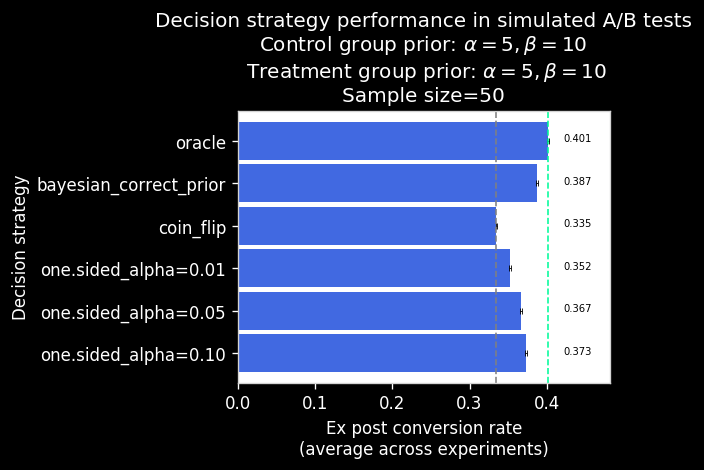

In [7]:
from functools import partial
dgp = partial(gen_one_dataset, 5, 10, 5, 10, N=50)
dfp = scenario(dgp, 10000)
plot_strategies(dfp)

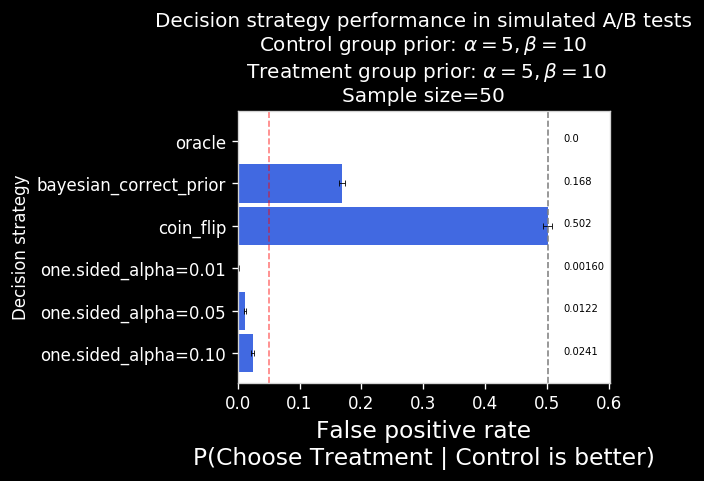

In [8]:
control_is_better = dfp['ate'] < 0
dfp_error = (False == dfp.eq(dfp['oracle'], axis=0))
ax = plot_strategies(dfp_error.loc[control_is_better])
ax.set_xlabel("False positive rate\nP(Choose Treatment | Control is better)", fontsize=14)
ax.axvline(0.05, linewidth=1, color='red', alpha=0.5, linestyle='--')

100% (10000 of 10000) |##################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (10000 of 10000) |##################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (10000 of 10000) |##################| Elapsed Time: 0:00:01 Time:  0:00:01
100% (10000 of 10000) |##################| Elapsed Time: 0:00:01 Time:  0:00:01
100% (10000 of 10000) |##################| Elapsed Time: 0:00:01 Time:  0:00:01


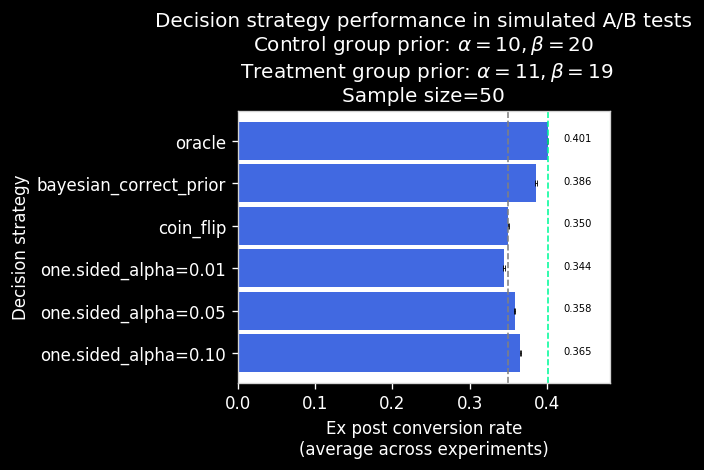

In [9]:
dgp = partial(gen_one_dataset, 10, 20, 11, 19, N=50)
dfp = scenario(dgp, 10000)
plot_strategies(dfp)

Text(0.5, 0, 'Type I error rate\nP(Choose Treatment | Control is better)')

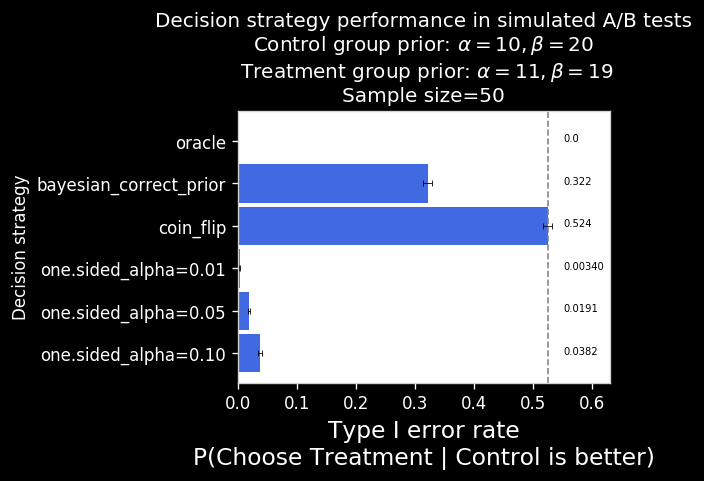

In [10]:
control_is_better = dfp['ate'] < 0
dfp_error = (False == dfp.eq(dfp['oracle'], axis=0))
ax = plot_strategies(dfp_error.loc[control_is_better])
ax.set_xlabel("Type I error rate\nP(Choose Treatment | Control is better)", fontsize=14)

100% (10000 of 10000) |##################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (10000 of 10000) |##################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (10000 of 10000) |##################| Elapsed Time: 0:00:01 Time:  0:00:01
100% (10000 of 10000) |##################| Elapsed Time: 0:00:01 Time:  0:00:01
100% (10000 of 10000) |##################| Elapsed Time: 0:00:01 Time:  0:00:01


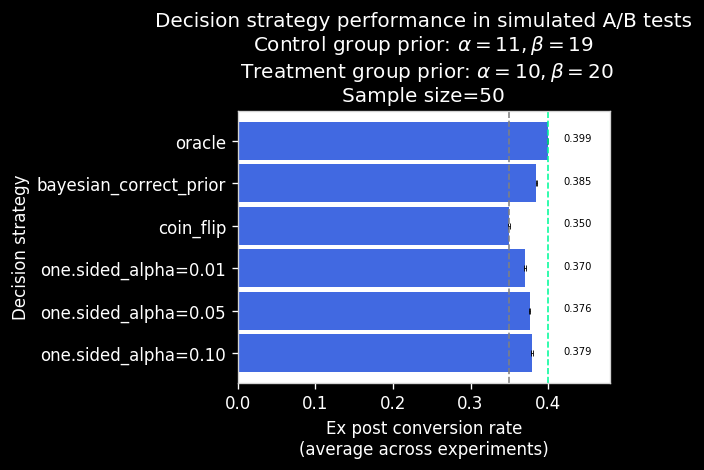

In [11]:
dgp = partial(gen_one_dataset, 11, 19, 10, 20, N=50)
dfp = scenario(dgp, 10000)
plot_strategies(dfp)

Text(0.5, 0, 'Type I error rate\nP(Choose Treatment | Control is better)')

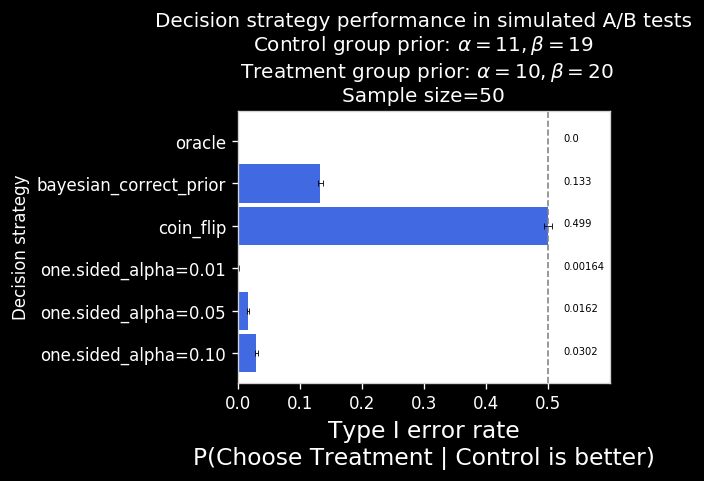

In [12]:
control_is_better = dfp['ate'] < 0
dfp_error = (False == dfp.eq(dfp['oracle'], axis=0))
ax = plot_strategies(dfp_error.loc[control_is_better])
ax.set_xlabel("Type I error rate\nP(Choose Treatment | Control is better)", fontsize=14)